In [60]:
import cobra
import pandas as pd
import re
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
import leakage, utils
import pubchempy as pcp
import seaborn as sns

In [2]:
def inf_to_100000(model):
    for r in model.reactions:
        if np.isinf(r.lower_bound):
            r.lower_bound = -100000
        if np.isinf(r.upper_bound):
            r.upper_bound = 100000
    return model

def print_summary(model, solution):
    # Print uptake
    for r in model.exchanges:
        flux = solution[r.id]
        if  flux >1e-3:
            print(r.id, r.name,flux, r.bounds)
        elif flux < -1e-3:
            print(r.id, r.name,flux, r.bounds)
    #print("## Demands ##")
    #for r in model.demands:
    #    print(r.id, solution[r.id])

    print("Growth: ", solution['r_2111'])
    print("Prot pool exchange: ", solution['prot_pool_exchange'])

In [3]:
model = cobra.io.read_sbml_model('../../models/yeast/ecYeastGEM_batch_8_3_4.xml')
model.solver = 'gurobi'
model = inf_to_100000(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-26


In [4]:
# Data on glucose uptake https://ami-journals.onlinelibrary.wiley.com/doi/10.1111/1751-7915.13995
init_glucose_conc = 16 #g/L
glucose_mw = 180.156 #g/mol
conc_gluc_mM = (init_glucose_conc/glucose_mw)*1e3
km_glc = 0.28 #mmol l−1
vmax_glc = 10 #mmol gDW−1

r_glc = vmax_glc * conc_gluc_mM / (conc_gluc_mM + km_glc)
print(r_glc)

9.968571784677293


## Note
As also stated in https://ami-journals.onlinelibrary.wiley.com/doi/10.1111/1751-7915.13995 glucose uptake is not constrained by km (i.e. vmax = 10)


In [124]:
model.reactions.get_by_id('r_1714_REV').upper_bound = 1
print_summary(model, model.optimize())

r_1672 carbon dioxide exchange 2.42827943791661 (0.0, 100000)
r_2100 water exchange 3.9994007124362203 (0.0, 100000)
r_1654_REV ammonium exchange (reversible) 0.5969829517664028 (0.0, 100000)
r_1714_REV D-glucose exchange (reversible) 1.0 (0.0, 1)
r_1832_REV H+ exchange (reversible) 0.7756881539766658 (0.0, 100000)
r_1992_REV oxygen exchange (reversible) 2.259538053212138 (0.0, 100000)
r_2005_REV phosphate exchange (reversible) 0.02383174026700467 (0.0, 100000)
r_2060_REV sulphate exchange (reversible) 0.007976640282786607 (0.0, 100000)
Growth:  0.08713478134253484
Prot pool exchange:  0.103720024310123


In [6]:
met_info_df = pd.read_csv("../../data/met_info_curated.csv", encoding = "ISO-8859-1", index_col = 0)

# Get leakage

In [125]:
time = 3
exometabolites_folder = Path("../../data/yeast/")
leakage_df = leakage.get_leakage(exometabolites_folder, "yeast", time = time, unit = '/gDW')
leakage_df.set_index("Metabolite", inplace=True)
leakage_df.drop_duplicates(inplace=True)
leakage_label = "Leakage (mM/gDW/h)"

In [126]:
# Read metabolite mapping
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0, usecols=[0,1,2,3])
df2 = pd.merge(leakage_df, mapping_df, left_index=True, right_index=True)
df2.drop(columns='Metabolite name', inplace=True)

In [127]:
df2

,Leakage (mM/gDW/h),Ecoli metabolite,Yeast metabolite
23PG,0.004460,"2pg, 3pg","s_0188, s_0260"
ACN,0.011501,acon_C,s_0516
ACT,474.593949,ac,s_0362
AKG,2.754506,akg,s_0180
ALA,0.026050,ala__L,s_0955
ARG,-15.539947,arg__L,s_0965
ASN,0.127593,asn__L,s_0969
ASP,0.030493,asp__L,s_0973
CIT,0.485549,cit,s_0522
DHAP,0.059542,dhap,s_0629


In [128]:
# leakage_df = leakage_df.loc[:, ['Leakage (mM/gDW/h)', 'Metabolite name', 'Yeast met id']]

In [129]:
df = pd.merge(met_info_df, df2, left_on = 'Metabolite id', right_on = 'Ecoli metabolite')

In [130]:
# df.drop(columns=['Topological Polar Surface Area [Å]'], inplace = True)

# Get logP values

In [131]:
xlogp_list = []
for i, row in df.iterrows():
    met_ids = row['Yeast metabolite'].split(', ')
    xlogp_temp_list = []
    # print(i, met_ids)
    for m_id in met_ids:
        try:
            m = model.metabolites.get_by_id('{0}[c]'.format(m_id))
        except KeyError:
            xlogp_temp_list.append(np.nan)
            print(m_id)
            continue
        result = pcp.get_compounds(m.name.replace(' [cytoplasm]',''), 'name')
        for r in result:
            print(m.id, r.xlogp)
            xlogp_temp_list.append(r.xlogp)
    xlogp_list.append(np.mean(xlogp_temp_list))

s_0568[c] -4.5
s_0568[c] -4.5
s_0557[c] -4.3


/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


s_0629[c] -2.5
s_0188[c] -2.6
s_0260[c] -2.1
s_1360[c] -1.1
s_1399[c] -0.6
s_0577[c] -3.7
s_0581[c] -3.7
s_0522[c] 0.2
s_0516[c] -1
s_0940[c] -1.8
s_0180[c] -0.9
s_0725[c] 1
s_0725[c] -0.3
s_0955[c] -3
s_1021[c] -1.5
s_1016[c] -1.7
s_1056[c] -2.3
s_0973[c] -2.8
s_1029[c] -1.9
s_1025[c] -3
s_1051[c] -2.3
s_1032[c] -1.5
s_1032[c] -1.5
s_0991[c] -3.7
s_0999[c] -3.1
s_1035[c] -2.5
s_1039[c] -3.1
s_0965[c] -4.2
s_1006[c] -3.2
s_0362[c] 0.4
s_0680[c] -0.1
s_1269[c] -0.8
s_1269[c] -1.4
s_1550[c] -1.1


In [132]:
# xlogp_list.append(np.nan)

In [133]:
df['log P'] = xlogp_list

In [134]:
df.loc[df['Metabolite id']=='fdp', 'log P'] = -5.9# https://pubchem.ncbi.nlm.nih.gov/compound/Fructose-1_6-bisphosphate#section=Computed-Properties
df.loc[df['Metabolite id']=='orot', 'log P'] = -0.8#https://pubchem.ncbi.nlm.nih.gov/compound/1492348#section=Chemical-and-Physical-Properties

# Get shadow prices and turnover flux

In [135]:
def get_turnover_flux(m, solution):
    total_flux = 0
    for r in m.reactions:
        flux_r = solution.fluxes[r.id]*r.get_coefficient(m_id)
        if flux_r > 0:
            total_flux += flux_r
    return total_flux


In [136]:
#sp = solution.shadow_prices
metabolites= []
for l in df['Yeast metabolite']:
    lst = l.split(", ")
    # if not isinstance(l, list):
    #     l = [l]
    for m in lst:
        metabolites.append('{0}[c]'.format(m))
# metabolites = ['{0}[c]'.format(m) for m in df['Yeast metabolite']]
all_shadow_prices = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = metabolites)

In [137]:
all_shadow_prices


{'s_0568[c]': -0.09450732406018902,
 's_0557[c]': -0.09450732406018902,
 's_0555[c]': -0.09884411389408654,
 's_0629[c]': -0.04942205694710017,
 's_0188[c]': -0.039594891183507286,
 's_0260[c]': -0.03959489118347953,
 's_1360[c]': -0.03959489118348786,
 's_1399[c]': -0.035258101349563975,
 's_0577[c]': -0.07947890168916033,
 's_0581[c]': -0.07947890168912841,
 's_0522[c]': -0.07080821321458763,
 's_0516[c]': -0.07080821321457376,
 's_0940[c]': -0.07080821321457376,
 's_0180[c]': -0.06329400202905178,
 's_0725[c]': -0.04508526711319155,
 's_0955[c]': -0.04277231253503044,
 's_1021[c]': -0.11126757117151803,
 's_1016[c]': -0.11762819626124216,
 's_1056[c]': -0.08641198303690478,
 's_0973[c]': -0.04710910236891408,
 's_1029[c]': -0.1323732816964962,
 's_1025[c]': -0.12081139999934737,
 's_1051[c]': -0.15317830812621863,
 's_1032[c]': -0.16069251931171424,
 's_0991[c]': -0.07080821321451686,
 's_0999[c]': -0.07514500304848237,
 's_1035[c]': -0.0895951867749975,
 's_1039[c]': -0.04161872643

In [138]:
# FBA
# I choose glucose uptake so low that there is no overflow metabolism
glucose_uptake = 4
model.reactions.get_by_id('r_1714_REV').upper_bound = glucose_uptake
solution = model.optimize()

turnover = {}
shadow_prices = {}
for i, row in df.iterrows():
    m_text = row["Yeast metabolite"]
    try:
        keys = m_text.split(",")
    except:
        print(m_text)
        continue
    sp_list = []
    turnover_list = []
    for key in keys:
        m_id = "{0}[c]".format(key.strip())
        m = model.metabolites.get_by_id(m_id)
        sp_list.append(all_shadow_prices[m.id])
        turnover_list.append(get_turnover_flux(m, solution))
    shadow_prices[i] = np.nanmean(sp_list)
    turnover[i] = np.mean(turnover_list)

In [139]:
df

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Topological Polar Surface Area,Concentration in E.coli,Leakage (mM/gDW/h),Ecoli metabolite,Yeast metabolite,log P
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,165.0,0.003000,0.011876,g6p,s_0568,-4.50
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,165.0,0.003000,0.020214,f6p,s_0557,-4.30
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,215.0,0.015200,0.014144,fdp,s_0555,-5.90
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,104.0,0.000374,0.059542,dhap,s_0629,-2.50
4,2/3-phosphoglycerate,"2pg, 3pg",183.033421,-3.0,1,124.0,0.001540,0.004460,"2pg, 3pg","s_0188, s_0260",-2.35
5,Phosphoenolpyruvate,pep,165.018141,-3.0,1,104.0,0.000184,0.000426,pep,s_1360,-1.10
6,Pyruvate,pyr,87.054120,-1.0,0,57.2,NaN,84.325065,pyr,s_1399,-0.60
7,Ribu-/Xylulose-5-phosphate,"ru5p__D, ru5p__L, xu5p__D, xu5p__L",228.093921,-2.0,1,145.0,0.000900,0.000700,"ru5p__D, ru5p__L, xu5p__D, xu5p__L","s_0577, s_0581",-3.70
8,Citrate,cit,189.099700,-3.0,0,141.0,0.001960,0.485549,cit,s_0522,0.20
9,Cis-aconitate,acon_C,171.084420,-3.0,0,112.0,0.000016,0.011501,acon_C,s_0516,-1.00


In [140]:
# # With glucose uptake = 3, there is a small flux "inconcistency" with accoa, gicing a positive shadow price
# with model:
#     model.add_boundary(model.metabolites.accoa_c, "demand")
#     model.optimize()
#     print(model.summary())

In [141]:
df["Shadow price"] = pd.Series(shadow_prices)
df["Turnover"] = pd.Series(turnover)

In [142]:
df

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Topological Polar Surface Area,Concentration in E.coli,Leakage (mM/gDW/h),Ecoli metabolite,Yeast metabolite,log P,Shadow price,Turnover
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,165.0,0.003000,0.011876,g6p,s_0568,-4.50,-0.094507,4.000000
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,165.0,0.003000,0.020214,f6p,s_0557,-4.30,-0.094507,3.518167
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,215.0,0.015200,0.014144,fdp,s_0555,-5.90,-0.098844,0.000000
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,104.0,0.000374,0.059542,dhap,s_0629,-2.50,-0.049422,3.203497
4,2/3-phosphoglycerate,"2pg, 3pg",183.033421,-3.0,1,124.0,0.001540,0.004460,"2pg, 3pg","s_0188, s_0260",-2.35,-0.039595,6.292741
5,Phosphoenolpyruvate,pep,165.018141,-3.0,1,104.0,0.000184,0.000426,pep,s_1360,-1.10,-0.039595,6.292741
6,Pyruvate,pyr,87.054120,-1.0,0,57.2,NaN,84.325065,pyr,s_1399,-0.60,-0.035258,6.967931
7,Ribu-/Xylulose-5-phosphate,"ru5p__D, ru5p__L, xu5p__D, xu5p__L",228.093921,-2.0,1,145.0,0.000900,0.000700,"ru5p__D, ru5p__L, xu5p__D, xu5p__L","s_0577, s_0581",-3.70,-0.079479,0.108153
8,Citrate,cit,189.099700,-3.0,0,141.0,0.001960,0.485549,cit,s_0522,0.20,-0.070808,2.916141
9,Cis-aconitate,acon_C,171.084420,-3.0,0,112.0,0.000016,0.011501,acon_C,s_0516,-1.00,-0.070808,2.916141


# Make predictions

In [143]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ARDRegression, BayesianRidge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from scipy import stats



In [144]:
df = df.loc[df['Leakage (mM/gDW/h)'] > 0, :]
# df.loc[df.Concentration.isna(), 'Concentration'] = np.mean(df.Concentration)
df["log10_value"] = np.log10(df['Leakage (mM/gDW/h)'])

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_2705/2529967008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log10_value"] = np.log10(df['Leakage (mM/gDW/h)'])


In [145]:
df = df.loc[df['Shadow price']< 0, :]

In [146]:

df["log10_sp"] = np.log10(np.abs(df[["Shadow price"]]))
# df["log10_conc"] = np.abs(np.log10(df.Concentration))

In [147]:
df

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Topological Polar Surface Area,Concentration in E.coli,Leakage (mM/gDW/h),Ecoli metabolite,Yeast metabolite,log P,Shadow price,Turnover,log10_value,log10_sp
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,165.0,0.003000,0.011876,g6p,s_0568,-4.50,-0.094507,4.000000,-1.925346,-1.024535
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,165.0,0.003000,0.020214,f6p,s_0557,-4.30,-0.094507,3.518167,-1.694354,-1.024535
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,215.0,0.015200,0.014144,fdp,s_0555,-5.90,-0.098844,0.000000,-1.849429,-1.005049
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,104.0,0.000374,0.059542,dhap,s_0629,-2.50,-0.049422,3.203497,-1.225179,-1.306079
4,2/3-phosphoglycerate,"2pg, 3pg",183.033421,-3.0,1,124.0,0.001540,0.004460,"2pg, 3pg","s_0188, s_0260",-2.35,-0.039595,6.292741,-2.350641,-1.402361
5,Phosphoenolpyruvate,pep,165.018141,-3.0,1,104.0,0.000184,0.000426,pep,s_1360,-1.10,-0.039595,6.292741,-3.370720,-1.402361
6,Pyruvate,pyr,87.054120,-1.0,0,57.2,NaN,84.325065,pyr,s_1399,-0.60,-0.035258,6.967931,1.925957,-1.452741
7,Ribu-/Xylulose-5-phosphate,"ru5p__D, ru5p__L, xu5p__D, xu5p__L",228.093921,-2.0,1,145.0,0.000900,0.000700,"ru5p__D, ru5p__L, xu5p__D, xu5p__L","s_0577, s_0581",-3.70,-0.079479,0.108153,-3.154961,-1.099748
8,Citrate,cit,189.099700,-3.0,0,141.0,0.001960,0.485549,cit,s_0522,0.20,-0.070808,2.916141,-0.313767,-1.149916
9,Cis-aconitate,acon_C,171.084420,-3.0,0,112.0,0.000016,0.011501,acon_C,s_0516,-1.00,-0.070808,2.916141,-1.939277,-1.149916


In [148]:
columns = ["log10_sp", "Turnover", "Mass", "Charge", "Phosphate", 'log P']#"Concentration", "Shadow price", "log10_conc", 



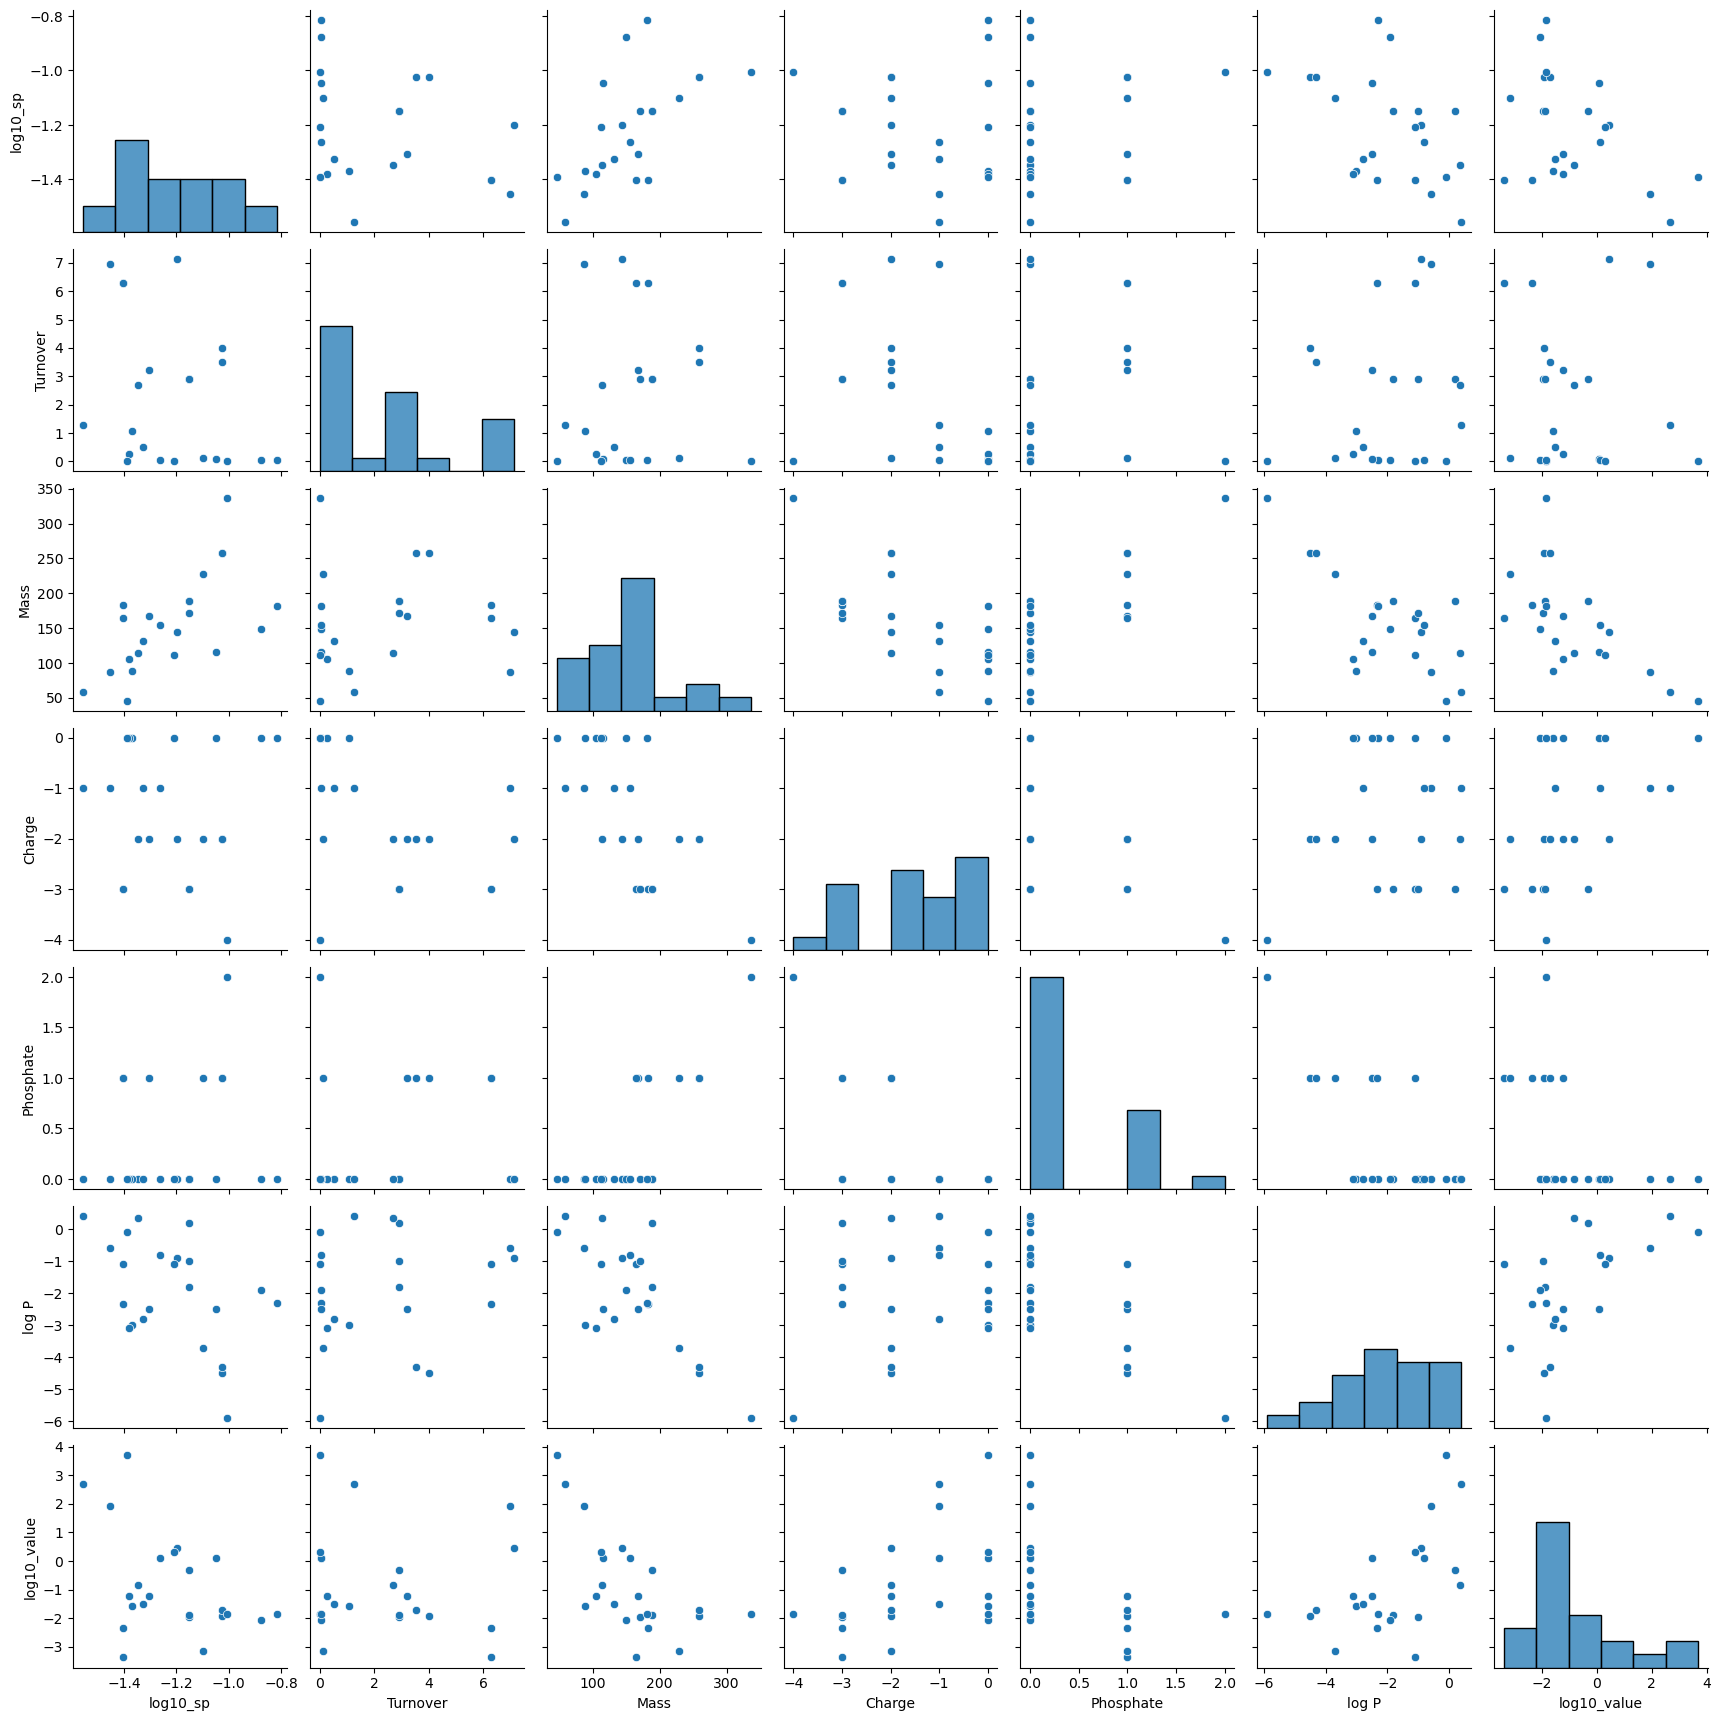

In [149]:
sns.pairplot(df[columns+['log10_value']])
plt.show()

log10_sp -0.4331431313254254 0.03896212660491829
Turnover -0.07203047961111533 0.7439656727461352
Mass -0.6486711680581071 0.000813586207543703
Charge 0.421396911715281 0.045217805078919274
Phosphate -0.47803015886727407 0.021048161682866478
log P 0.5725374466165588 0.004302484760542958


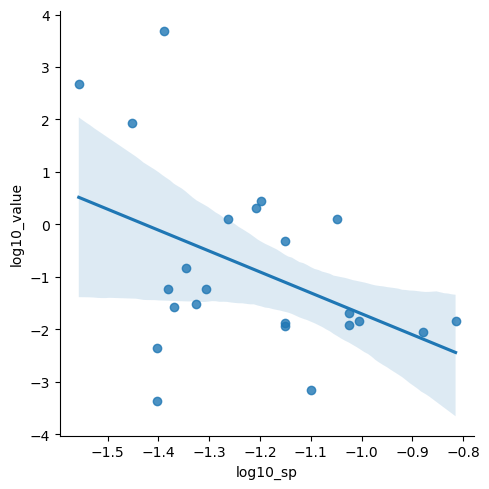

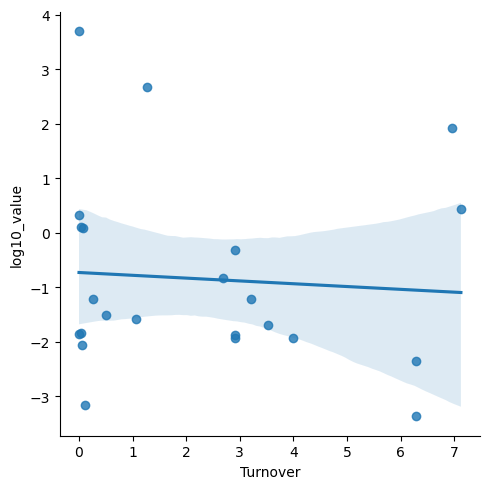

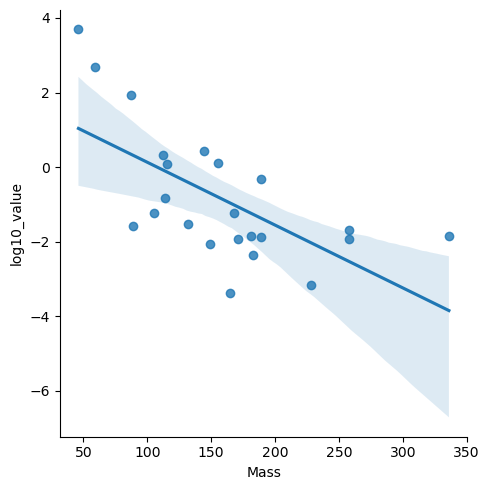

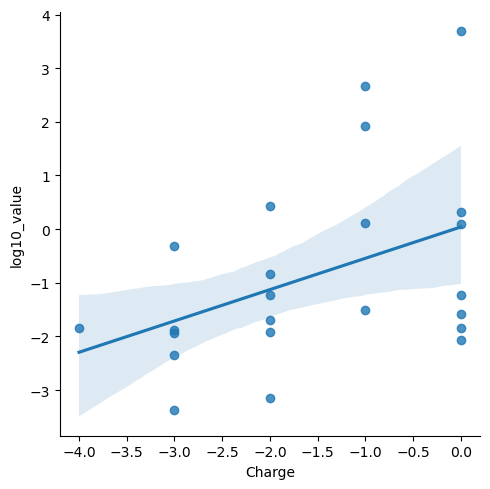

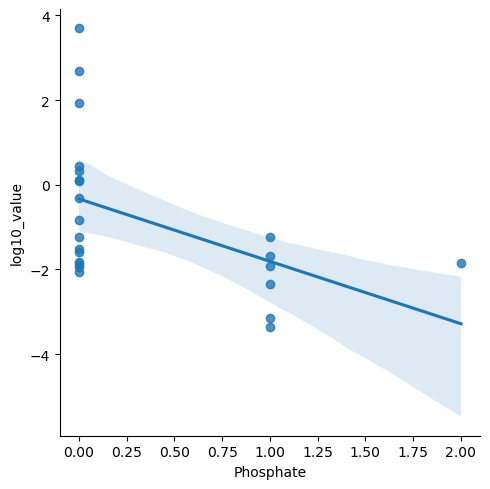

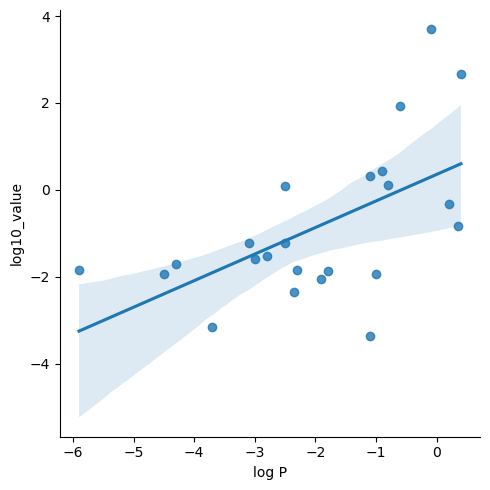

In [170]:
import scipy as sp
for c in columns:
    sns.lmplot(data = df, x = c, y = 'log10_value')

    r, p = sp.stats.pearsonr(df.loc[:,c], df.loc[:,'log10_value'])
    print(c, r, p)

## Make train and test set

In [150]:
data = StandardScaler().fit_transform(df[columns])
X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.1)#, random_state=40)


In [151]:
N = 100
coefficients = np.zeros((6,N))*np.nan

R2_arr = np.zeros(N)
R2_arr_test = np.zeros(N)
data = StandardScaler().fit_transform(df[columns])

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.05)
    linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
    coefficients[:, i] = linear_reg.coef_
    R2_arr[i] = linear_reg.score(X_train, y_train)


In [152]:
len(coefficients.mean(axis = 1)), len(columns)

(6, 6)

<BarContainer object of 6 artists>

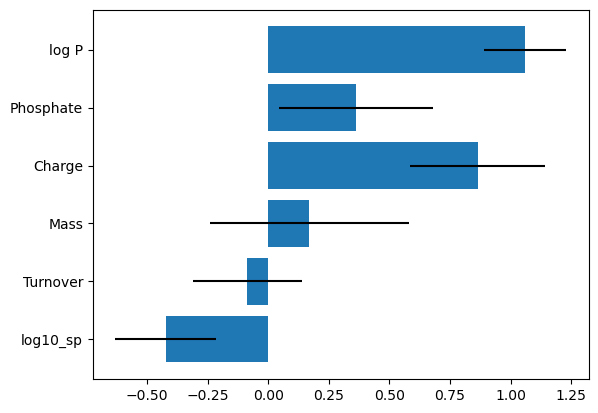

In [156]:
plt.barh(columns, coefficients.mean(axis=1), xerr = coefficients.std(axis=1))

<BarContainer object of 1 artists>

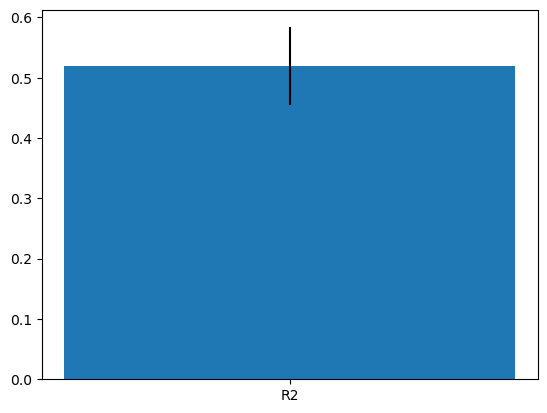

In [155]:
plt.bar(["R2"], [R2_arr.mean()], yerr = [R2_arr.std()])

# Statsmodels

In [157]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Look at correlation between variables

In [158]:
# columns =  ["Turnover", "Mass", "Charge", "Phosphate", "Topological Polar Surface Area [Å]","log10_sp", "log10_conc", "Shadow price", "Concentration"]
# columns =  ["log10_sp", "Charge"] #"log10_value" "Topological Polar Surface Area [Å]", 
data = StandardScaler().fit_transform(df[columns])

In [159]:
df_i = df[columns]
rho = df_i.corr()
pval = df_i.corr(method=lambda x, y: st.pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

,log10_sp,Turnover,Mass,Charge,Phosphate,log P
log10_sp,1.0***,-0.3,0.62**,-0.03,0.19,-0.48*
Turnover,-0.3,1.0***,0.07,-0.5*,0.17,0.19
Mass,0.62**,0.07,1.0***,-0.67***,0.78***,-0.71***
Charge,-0.03,-0.5*,-0.67***,1.0***,-0.61**,0.17
Phosphate,0.19,0.17,0.78***,-0.61**,1.0***,-0.7***
log P,-0.48*,0.19,-0.71***,0.17,-0.7***,1.0***


In [160]:
pval

,log10_sp,Turnover,Mass,Charge,Phosphate,log P
log10_sp,0.000000,0.157908,0.001530,0.902099,0.394206,0.021128
Turnover,0.157908,0.000000,0.739228,0.015374,0.442297,0.384227
Mass,0.001530,0.739228,0.000000,0.000464,0.000012,0.000134
Charge,0.902099,0.015374,0.000464,0.000000,0.001920,0.448112
Phosphate,0.394206,0.442297,0.000012,0.001920,0.000000,0.000230
log P,0.021128,0.384227,0.000134,0.448112,0.000230,0.000000


In [161]:
data = sm.add_constant(data)

In [162]:
y = StandardScaler().fit_transform(df.log10_value.values[:, np.newaxis])

In [163]:
y.std()

0.9999999999999999

In [164]:
ols_model = sm.OLS(y, data)

In [165]:
results = ols_model.fit()

In [166]:
df[columns].columns

Index(['log10_sp', 'Turnover', 'Mass', 'Charge', 'Phosphate', 'log P'], dtype='object')

In [167]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     2.623
Date:                Wed, 05 Apr 2023   Prob (F-statistic):             0.0577
Time:                        01:08:34   Log-Likelihood:                -24.759
No. Observations:                  23   AIC:                             63.52
Df Residuals:                      16   BIC:                             71.47
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.163e-17      0.178  -2.35e-16      1.0